In [9]:
!pip install gymnasium[atari]==1.0
!pip install ale_py

  Using cached ale_py-0.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
Using cached ale_py-0.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.5
    Uninstalling ale-py-0.7.5:
      Successfully uninstalled ale-py-0.7.5


In [61]:
import gymnasium as gym
import ale_py

env = gym.make("ALE/Freeway-v5", difficulty = 0, mode = 1, obs_type = "rgb", render_mode = "rgb_array")

print(f"Action space is {env.action_space}") # NOOP, UP, DOWN
print(f"Observation space is {env.observation_space}") # Image of 210 x 160 px

Action space is Discrete(3)
Observation space is Box(0, 255, (210, 160, 3), uint8)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
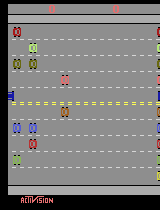

In [62]:
env.reset()
env.render()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
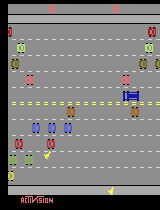

In [65]:
env.step(1)
env.step(1)
env.step(1)
array = env.render()
array

In [67]:
import numpy
np.save("freeway.npy", array)

In [14]:
import numpy as np
from collections import defaultdict
import sys

def make_epsilon_greedy_policy(Q, epsilon, num_Actions):
    """
    Creates an epsilon-greedy policy based on a Q and epsilon action value function

    Args:
         Q: A dictionary whose correspondence is state -> action-values.
            Each value is a numpy array of length num_Actions (see below)
         epsilon: The probability of selecting a random action (float between 0 and 1).
         num_Actions: Number of actions in the environment. (in the case of WIndyGridWorld it is 4)

    Returns:
         A function that takes the observation as an argument and returns as a result
         the probabilities of each action as a numpy array of length num_Actions.
    """
    def policy_fn(observation):
        A = np.ones(num_Actions, dtype=float) * epsilon / num_Actions
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)

        return A

    return policy_fn


def mc_control_on_policy_epsilon_greedy(env, num_episodes, discount=1.0, epsilon=0.1, epsilon_decay=0.9):
    """
    Control by Monte Carlo methods using Epsilon-Greedy policies
    Find an epsilon-greedy policy.

    Args:
         env: Gymnasium environment.
         num_episodes: Number of episodes in the sample.
         discount: discount factor.
         epsilon: The probability of selecting a random action (float between 0 and 1)

    Returns:
         A tuple (Q, policy).
         Q: A dictionary whose correspondence is state -> action-values.
         policy: A function that takes the observation as an argument and returns as a result
                 the probabilities of each action
    """

    # We store the sum and number of returns for each state to calculate the average.
    # We could use an array to store all the returns, but it is inefficient in terms of memory.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The Q action value function.
    # A nested dictionary whose correspondence is state -> (action -> action-value).
    # Initially we initialize it to zero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Rewards
    y = np.zeros(num_episodes, dtype=np.float16)

    for i_episode in range(num_episodes):
        # The policy we are following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

        # We update epsilon
        epsilon = max(epsilon * epsilon_decay, 0.01)

        # We generate an episode and store it
        # An episode is an array of tuples (state, action, reward)
        episode = []
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state

        y[i_episode] = total_reward
        idx = 0

        # We visited all the states of the episode
        G = 0
        for i in range(len(episode)-1, -1, -1):
            x = episode[i]
            state = x[0]
            action = x[1]
            reward = x[2]
            sa_pair = (state, action)
            # We calculate the return of each state
            G = reward + discount * G
            # We calculate the average return for this state across all sampled episodes.
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            idx = idx + 1

        # write to summary
        # writer.add_scalar("reward", total_reward, i_episode)

        # We print which episode we are in, useful for debugging.
        if i_episode % 100 == 0 and i_episode > 0:
            print("\rEpisode {:8d}/{:8d} - Average reward {:.2f}".format(i_episode, num_episodes, np.average(y[(i_episode-100):i_episode])), end="")
            sys.stdout.flush()

        # The policy is implicitly improved by changing the values of Q

    return Q, policy

In [ ]:
# Execute
Q, policy = mc_control_on_policy_epsilon_greedy(env, num_episodes=50000, discount=1, epsilon=1, epsilon_decay=0.999)